In [1]:
import sys
print(sys.executable)


/opt/anaconda3/envs/inventory/bin/python3.11


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet

print("All libraries are working fine!")

Importing plotly failed. Interactive plots will not work.


All libraries are working fine!


In [3]:
# --- Step 1: Import libraries ---
import pandas as pd
import numpy as np

# --- Step 2: Create synthetic sales data ---
# Generate 90 days of data
dates = pd.date_range(start="2024-07-01", end="2024-09-30")

# Example auto parts sold by AutoZone-like retailers
products = ["Brake Pads", "Oil Filter", "Spark Plug", "Car Battery", "Air Filter"]
regions = ["East", "West", "North", "South"]

# --- Step 3: Generate data combinations ---
data = []
np.random.seed(42)  # for reproducibility

for date in dates:
    for product in products:
        for region in regions:
            units_sold = np.random.randint(10, 200)
            data.append([date, product, region, units_sold])

# --- Step 4: Create DataFrame ---
df = pd.DataFrame(data, columns=["Date", "Product", "Region", "Units_Sold"])

# --- Step 5: Save and preview ---
df.to_csv("sales_data.csv", index=False)
df.head(10)

,Date,Product,Region,Units_Sold
0,2024-07-01,Brake Pads,East,112
1,2024-07-01,Brake Pads,West,189
2,2024-07-01,Brake Pads,North,102
3,2024-07-01,Brake Pads,South,24
4,2024-07-01,Oil Filter,East,116
5,2024-07-01,Oil Filter,West,81
6,2024-07-01,Oil Filter,North,198
7,2024-07-01,Oil Filter,South,30
8,2024-07-01,Spark Plug,East,112
9,2024-07-01,Spark Plug,West,131


In [4]:
import pandas as pd

# Load the data
df = pd.read_csv("sales_data.csv")

# Show first few rows
print("Preview of dataset:")
display(df.head())

# Check basic info
print("\nDataset Info:")
df.info()

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

Preview of dataset:


,Date,Product,Region,Units_Sold
0,2024-07-01,Brake Pads,East,112
1,2024-07-01,Brake Pads,West,189
2,2024-07-01,Brake Pads,North,102
3,2024-07-01,Brake Pads,South,24
4,2024-07-01,Oil Filter,East,116



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1840 entries, 0 to 1839
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Date        1840 non-null   object
 1   Product     1840 non-null   object
 2   Region      1840 non-null   object
 3   Units_Sold  1840 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 57.6+ KB

Missing values per column:
Date          0
Product       0
Region        0
Units_Sold    0
dtype: int64


In [5]:
# Aggregate total daily sales per product
daily_sales = df.groupby(["Date", "Product"])["Units_Sold"].sum().reset_index()

print("Aggregated daily sales:")
display(daily_sales.head(10))

Aggregated daily sales:


,Date,Product,Units_Sold
0,2024-07-01,Air Filter,372
1,2024-07-01,Brake Pads,427
2,2024-07-01,Car Battery,509
3,2024-07-01,Oil Filter,425
4,2024-07-01,Spark Plug,424
5,2024-07-02,Air Filter,642
6,2024-07-02,Brake Pads,450
7,2024-07-02,Car Battery,599
8,2024-07-02,Oil Filter,464
9,2024-07-02,Spark Plug,255


17:15:45 - cmdstanpy - INFO - Chain [1] start processing
17:15:45 - cmdstanpy - INFO - Chain [1] done processing


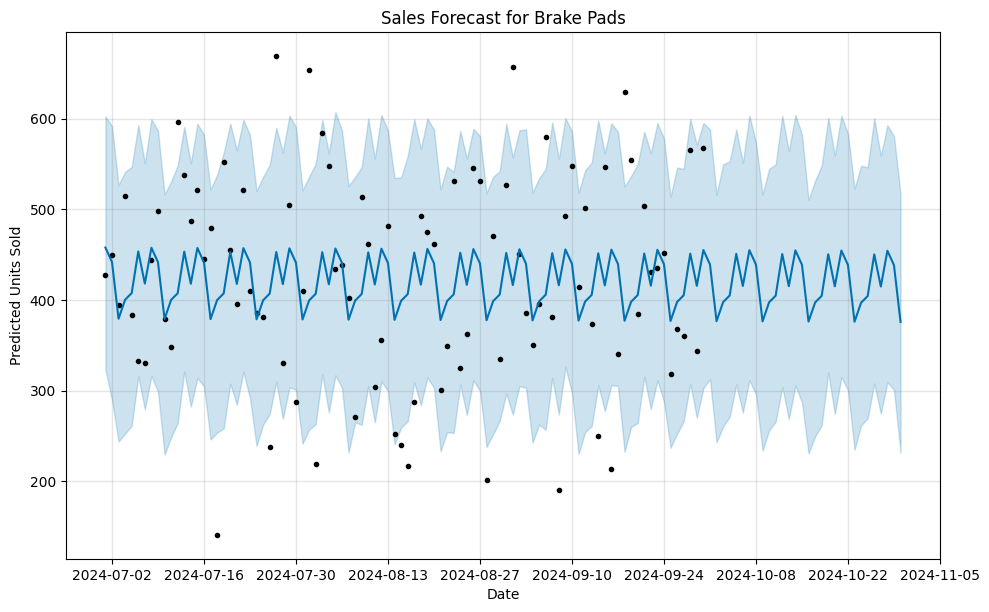

In [6]:
from prophet import Prophet
import matplotlib.pyplot as plt

# Filter data for one product
product_name = "Brake Pads"
product_data = daily_sales[daily_sales["Product"] == product_name][["Date", "Units_Sold"]]

# Prophet requires columns named ds (date) and y (target)
product_data.rename(columns={"Date": "ds", "Units_Sold": "y"}, inplace=True)

# Create and fit model
model = Prophet()
model.fit(product_data)

# Make future dataframe (next 30 days)
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Plot forecast
model.plot(forecast)
plt.title(f"Sales Forecast for {product_name}")
plt.xlabel("Date")
plt.ylabel("Predicted Units Sold")
plt.show()

In [10]:
forecast.to_csv(f"{product_name}_forecast.csv", index=False)

In [7]:
# Forecast for all products and compare results
summary = []

for product in df["Product"].unique():
    subset = daily_sales[daily_sales["Product"] == product][["Date", "Units_Sold"]]
    subset.rename(columns={"Date": "ds", "Units_Sold": "y"}, inplace=True)
    
    model = Prophet()
    model.fit(subset)
    future = model.make_future_dataframe(periods=30)
    forecast = model.predict(future)
    
    # Calculate average of last 30 days (future) and last 30 days (past)
    future_mean = forecast.tail(30)["yhat"].mean()
    past_mean = subset.tail(30)["y"].mean()
    change = future_mean - past_mean
    
    summary.append([product, round(past_mean, 2), round(future_mean, 2), round(change, 2)])

# Create results DataFrame
summary_df = pd.DataFrame(summary, columns=["Product", "Past_Sales", "Forecasted_Sales", "Change"])
summary_df.sort_values(by="Change", ascending=False, inplace=True)
summary_df.reset_index(drop=True, inplace=True)
summary_df

17:19:29 - cmdstanpy - INFO - Chain [1] start processing
17:19:29 - cmdstanpy - INFO - Chain [1] done processing
17:19:29 - cmdstanpy - INFO - Chain [1] start processing
17:19:29 - cmdstanpy - INFO - Chain [1] done processing
17:19:29 - cmdstanpy - INFO - Chain [1] start processing
17:19:29 - cmdstanpy - INFO - Chain [1] done processing
17:19:29 - cmdstanpy - INFO - Chain [1] start processing
17:19:29 - cmdstanpy - INFO - Chain [1] done processing
17:19:29 - cmdstanpy - INFO - Chain [1] start processing
17:19:29 - cmdstanpy - INFO - Chain [1] done processing


,Product,Past_Sales,Forecasted_Sales,Change
0,Spark Plug,400.20,392.93,-7.27
1,Air Filter,393.87,384.91,-8.96
2,Car Battery,415.83,406.37,-9.46
3,Brake Pads,432.67,418.72,-13.95
4,Oil Filter,399.87,373.18,-26.68


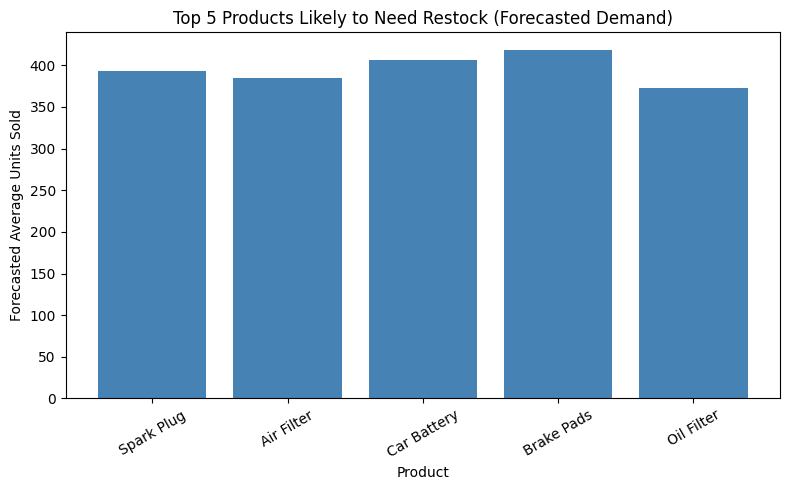

In [8]:
import matplotlib.pyplot as plt

top5 = summary_df.head(5)

plt.figure(figsize=(8, 5))
plt.bar(top5["Product"], top5["Forecasted_Sales"], color="steelblue")
plt.title("Top 5 Products Likely to Need Restock (Forecasted Demand)")
plt.xlabel("Product")
plt.ylabel("Forecasted Average Units Sold")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

In [9]:
summary_df.to_csv("product_demand_summary.csv", index=False)
